In [1]:
import os, sys, time
import argparse
import yaml

import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torchvision.utils as vutils
import matplotlib.pyplot as plt

from cond_diffusion_denoiser import CIFAR10DenoiseDataset, UNetCond, CondDDPM

In [2]:
def load_config(yaml_path):
    """Load parameters from YAML config file."""
    with open(yaml_path, 'r') as f:
        config = yaml.safe_load(f)
    return config

yaml_config = "./configs/default.yaml"
params = load_config(yaml_config)

In [3]:
augs = T.RandomHorizontalFlip(p=0.5)

train_ds = CIFAR10DenoiseDataset(
    train=True, 
    fixed_sigma=None, 
    sigma_range=(params['train_sigma_min'], params['train_sigma_max']), 
    extra_transform=augs
)
val_ds = CIFAR10DenoiseDataset(
    train=False, 
    fixed_sigma=params['val_sigma'],
    sigma_range=(params['val_sigma'], params['val_sigma']), 
    extra_transform=None
)

train_dl = DataLoader(
    train_ds, 
    batch_size=params['batch_size'], 
    shuffle=True, 
    num_workers=params['num_workers'], 
    pin_memory=True
)
val_dl = DataLoader(
    val_ds, 
    batch_size=params['val_batch_size'], 
    shuffle=False, 
    num_workers=params['num_workers']//2, 
    pin_memory=True
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

Device: cuda


In [5]:
from collections import OrderedDict

def load_trained_model(checkpoint_path):
    """
    Load a trained conditional diffusion model from a checkpoint.
    Args:
        checkpoint_path (str): Path to the saved model checkpoint
    Returns:
        model (UNetCond): The loaded model
        ddpm (CondDDPM): The diffusion model with proper timesteps
    """
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)
    
    # Get configuration
    cfg = checkpoint['cfg']
    T = cfg['T']  # number of timesteps
    Cx = cfg['Cx']  # number of channels
    
    # Initialize model and diffusion
    model = UNetCond(
        in_ch=Cx+Cx,  # input channels (noisy image + clean image)
        base=params['base_channels'],      # base channels from config
        time_dim=params['time_dim'], # default time embedding dimension
        out_ch=Cx     # output channels (clean image)
    ).to(device)

    # Load the trained weights
    try:
        model.load_state_dict(checkpoint['model'])
    except:  ## For single-GPU inference on a model trained by DDP
        new_state_dict = OrderedDict()
        for key, val in checkpoint['model'].items():
            name = key[7:]
            new_state_dict[name] = val 
        model.load_state_dict(new_state_dict)
    
    model.eval()  # set to evaluation mode
    
    # Initialize diffusion model with saved timesteps
    ddpm = CondDDPM(T=T, device=device)
    
    return model, ddpm

In [6]:
@torch.no_grad()
def visualize_batch(model, ddpm, val_dl, steps=100, eta=0.0, start_index=0, max_n=8):
    model.eval()
    x0, y = next(iter(val_dl))
    x0, y = x0.to(device), y.to(device)
    x_hat = ddpm.ddim_sample(model, y, shape=x0.shape[1:], eta=eta, steps=steps)

    # make a grid: top = clean, mid = noisy, bottom = denoised
    def to_grid(t):
        # clamp and grid
        t = t.clamp(0,1).cpu()
        return vutils.make_grid(t[start_index:start_index+max_n], nrow=max_n, padding=2)

    grid_clean   = to_grid(x0)
    grid_noisy   = to_grid(y)
    grid_denoise = to_grid(x_hat)

    fig, axes = plt.subplots(3, 1, figsize=(max_n*1.5, 4.5))
    for ax, grid, title in zip(axes, [grid_clean, grid_noisy, grid_denoise], ["Clean", "Noisy (input)", "Denoised (DDIM)"]):
        ax.imshow(np.transpose(grid.numpy(), (1,2,0)))
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

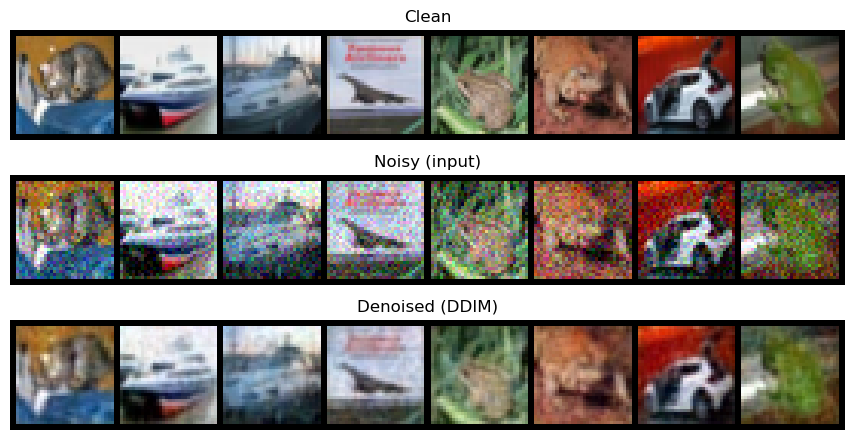

In [26]:
model, ddpm = load_trained_model('cifar10_cond_diffusion_2.pth')
visualize_batch(model, ddpm, val_dl, steps=100, eta=0.0, start_index=0, max_n=8)

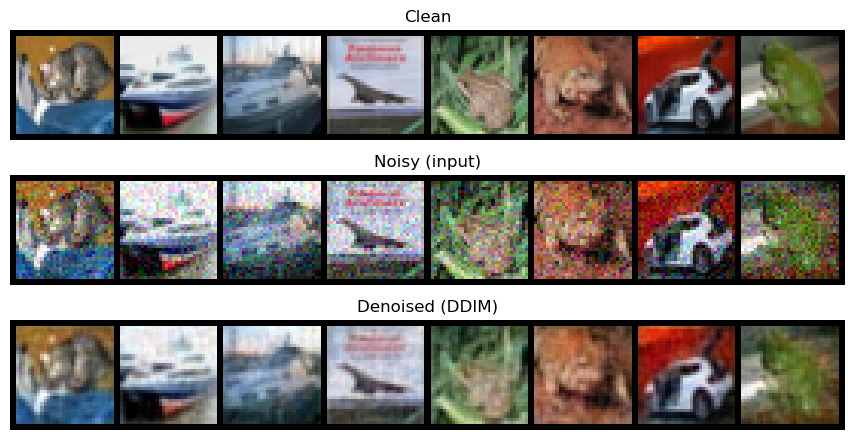

In [25]:
model, ddpm = load_trained_model('cifar10_cond_diffusion.pth')
visualize_batch(model, ddpm, val_dl, steps=100, eta=0.0, start_index=0, max_n=8)

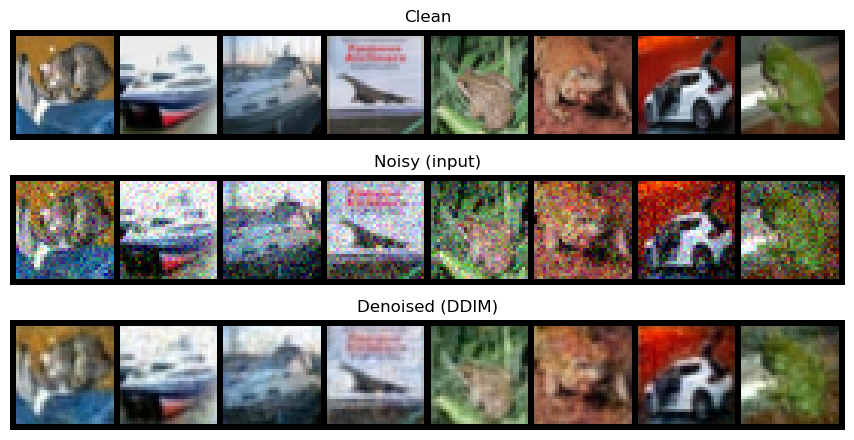

In [24]:
model, ddpm = load_trained_model('cifar10_cond_diffusion_3.pth')
visualize_batch(model, ddpm, val_dl, steps=100, eta=0.0, start_index=0, max_n=8)

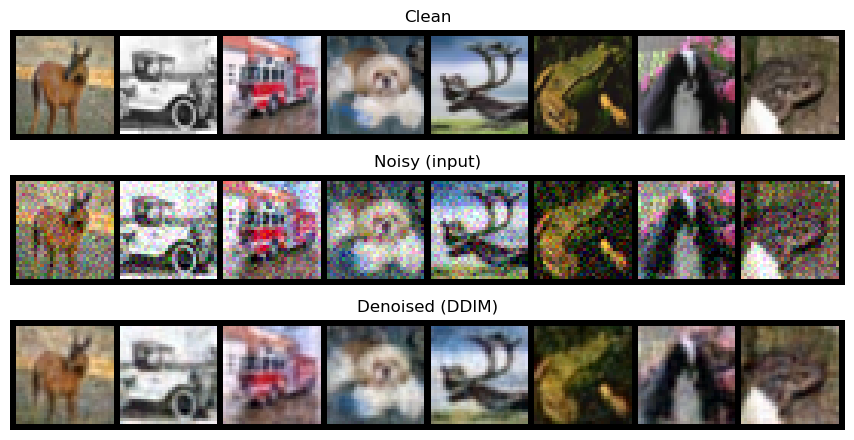

In [53]:
model, ddpm = load_trained_model('cifar10_cond_diffusion_2.pth')
visualize_batch(model, ddpm, val_dl, steps=100, eta=0.0, start_index=36, max_n=8)

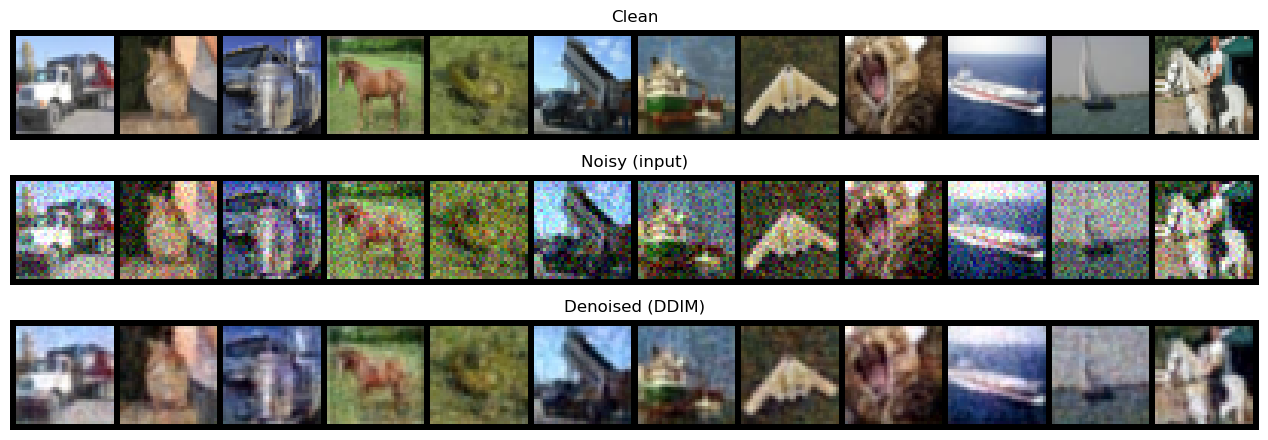

In [63]:
model, ddpm = load_trained_model('cifar10_cond_diffusion_4.pth')
visualize_batch(model, ddpm, val_dl, steps=100, eta=0.0, start_index=45, max_n=12)

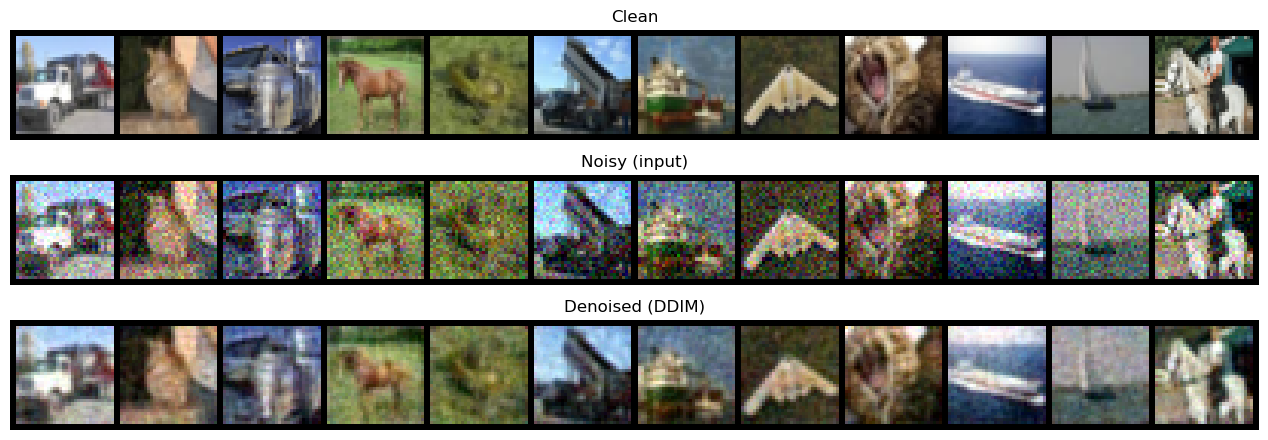

In [62]:
model, ddpm = load_trained_model('cifar10_cond_diffusion_5.pth')
visualize_batch(model, ddpm, val_dl, steps=100, eta=0.0, start_index=45, max_n=12)

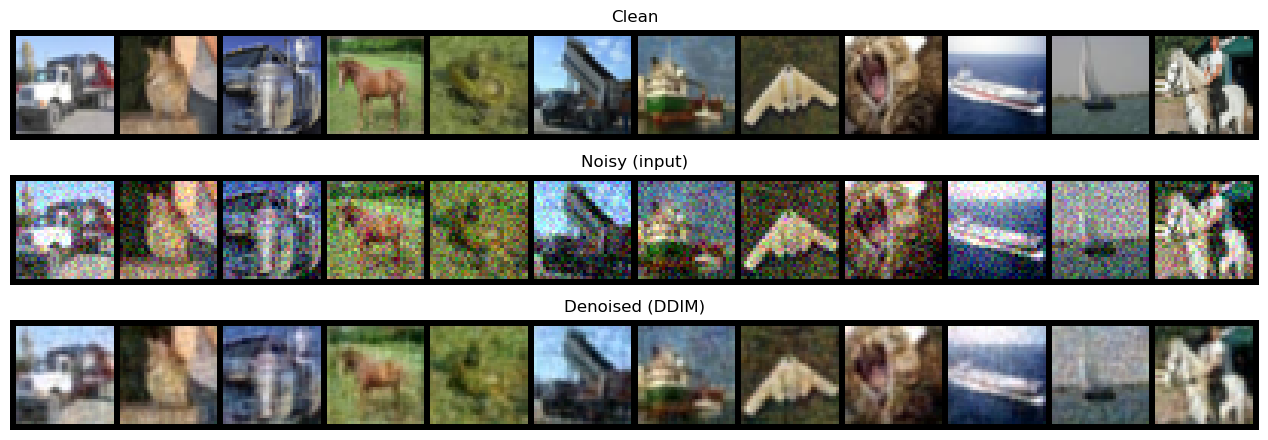

In [68]:
model, ddpm = load_trained_model('cifar10_cond_diffusion_ep20.pth')
visualize_batch(model, ddpm, val_dl, steps=100, eta=0.0, start_index=45, max_n=12)

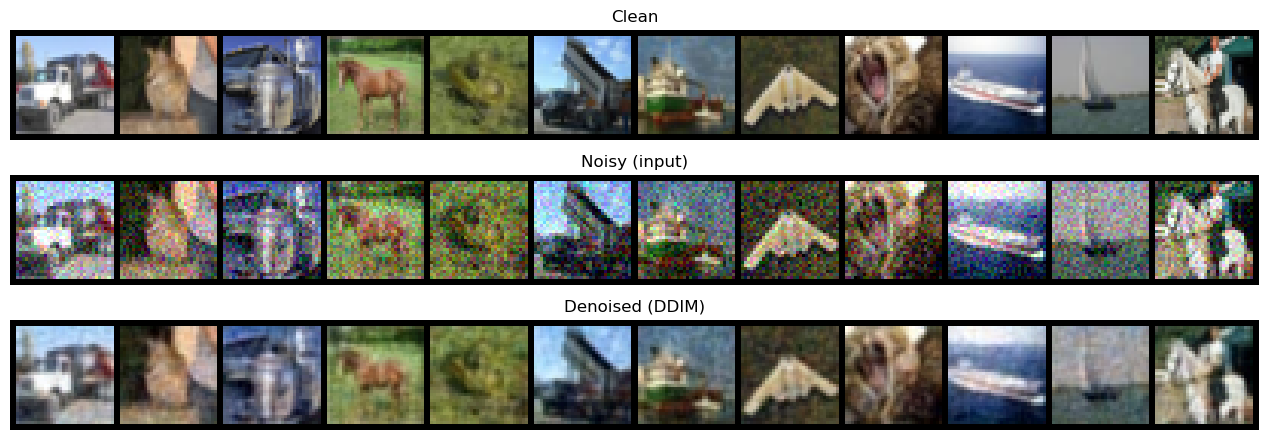

In [13]:
model, ddpm = load_trained_model('cifar10_cond_diffusion_new.pth')
visualize_batch(model, ddpm, val_dl, steps=30, eta=0.0, start_index=45, max_n=12)